## Load data

In [1]:
import os
import numpy as np
import librosa

#50 speakers audio data with length more than 1 hour for each. Wav format, 16KHz, mono channel and is split into 1min chunks. Scraped from YouTube and Librivox.
data_dir_path = '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data'


def load_images(sr=16000, file_duration_sec=60) -> (np.ndarray, np.ndarray, np.ndarray):
    print("[INFO] Loading data...")
    
    file_data = []
    file_names = []
    #features = []
    labels = []
    
    speakers_count = len(os.listdir(data_dir_path))
    
    i = 0
    for speaker_dir in os.listdir(data_dir_path):
        speaker_dir_path = os.path.join(data_dir_path, speaker_dir)
        speaker_id = speaker_dir[-4:]
        if i == 51:
            break
        i=i+1
        print(f"[INFO] Loading data for user {speaker_id}...")
        numb_of_samples = 0
        for audio_file in os.listdir(speaker_dir_path):
            audio_path = os.path.join(speaker_dir_path, audio_file)
            try:
                y, sr = librosa.load(audio_path, sr=sr)
                
                # if len(features) > 0 and features[-1].shape != spect.shape:
                #     print(f"Shape of input file {audio_file} doesn't match previous one, skipping.")
                #     continue
                # 
                # features.append(spect)
                
                # load file only longer then 55 seconds
                if len(y) > 55 * sr:
                    # Apply padding so files are the same length
                    audio_length = y.shape[0]
                    pad_length = file_duration_sec*sr - audio_length
                    
                    if pad_length > 0:
                        to_insert = np.pad(y, (0, pad_length), mode='constant')
                    else:
                        to_insert = y[:file_duration*sr]  # If length matches, no padding is needed
                       
                    file_data.append(to_insert)
                        
                    file_names.append(audio_file)
                    labels.append(int(speaker_id))  # Assign label (speaker id)
                    numb_of_samples = numb_of_samples + 1
                    
                    #print(f"[DEBUG] Loading file {audio_file} with length {len(y)/sr}.")
                    
            except Exception as e:
                print(f"[ERROR] Error loading audio file: {audio_path}. Error: {e}")
        
        print(f"[INFO] Loaded a total of {numb_of_samples} samples for user {speaker_id}.")
        print(f"[INFO] [{i}/{speakers_count}] speakers loaded.")
        
    # Convert lists to numpy arrays for further processing
    #features = np.array(features)
    labels = np.array(labels)
    file_names = np.array(file_names)
    file_data = np.array(file_data)
    
    # Print the shapes to verify
    #print("Features shape:", features.shape)
    print("Audio files array shape:", file_data.shape)
    print("Labels shape:", labels.shape)
    
    #print(f"[INFO] Loaded {features.shape[0]} files.")
    print(f"[INFO] Loaded a total of {len(labels)} audio files.")
    print(f"[INFO] Used sample rate: {sr}, padded file to length of: {file_duration_sec}s.")
    
    # return features, labels, audio_data
    return file_data, labels, file_names

## Extract features

In [9]:
def extract_features(file_data, file_names, sr=16000) -> np.ndarray:
    print(f"[INFO] Extracting features...")
    features = []
    
    for i, data in enumerate(file_data):
        spect = extract_mel_spectrogram(data, sr, False)
        # spect = extract_stft_spectrogram(data, sr, False)
        # spect = extract_MFCCs(data, sr, False)
        # spect = extract_spectral_centroid(data, False)
        # spect = extract_features_means(data, sr) # 1D tests
        
        features.append(spect)
        print(f"[INFO] Extracted features for speaker {labels[i]} from audio files.")
        
    # Convert lists to numpy arrays for further processing
    features = np.array(features)
    
    print(f"[INFO] Extracted features for {len(file_data)} audio files.")
    
    # Print the shapes to verify
    print("Features shape:", features.shape)
        
    return features    

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

def extract_MFCCs(y, sr, show_plt: bool) -> np.ndarray:    
    # MFCC — Mel-Frequency Cepstral Coefficients
    # This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.title('MFCC')
        plt.colorbar()
        plt.show() 
    
    return mfccs
    
def extract_stft_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # Short Term Fourier Transform (STFT) converts signal such that we can know the amplitude of given frequency at a given time. 
    # It has all the frequency bands from the FFT, (n_fft/2)+1 bands, 1025 for n_fft=2048.
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    
    # You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. There are some additional details going on behind the scenes when computing the spectrogram. The y-axis is converted to a log scale, and the color dimension is converted to decibels (you can think of this as the log scale of the amplitude). This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.
    spect = np.abs(stft)
    spect = librosa.amplitude_to_db(spect, ref=np.max) # Convert an amplitude spectrogram to dB-scaled spectrogram.
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
        plt.title('Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show() 
        
    return spect

def extract_mel_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # We are better at detecting differences in lower frequencies than higher frequencies.
    # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.
    
    # Where-as the mel-spectrogram has mel filters applied which reduces the number of bands to n_mels (typically 32-128)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mel_spect, sr=sr, y_axis='mel', fmax=8000, x_axis='time')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        
    return mel_spect

# very high overfitting factor -> no sense
def extract_spectral_centroid(y, show_plt: bool) -> np.ndarray:
    # Spectral Centroid 
    # It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.
    
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    spectrogram = np.abs(stft)
    
    spectral_centroids = librosa.feature.spectral_centroid(S=spectrogram)
    
    times = librosa.times_like(spectral_centroids)
    
    if show_plt:
        fig, ax = plt.subplots(figsize=(14, 5))
        librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),  y_axis='log', x_axis='time', ax=ax)
        
        ax.plot(times, spectral_centroids.T, label='Spectral centroid', color='w')
        ax.legend(loc='upper right')
        ax.set(title='log Power spectrogram')
        plt.show()
    
    return spectral_centroids

def extract_chroma_stft(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    
    return chroma_stft

def extract_spectral_contrast(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    spec_contr = librosa.feature.spectral_contrast(S=stft, sr=sr)
    
    return spec_contr

def extract_features_means(y, sr) -> np.ndarray:
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = extract_MFCCs(y, sr, False)
    mfccs = np.mean(mfccs.T, axis=0)

    # Computes a mel-scaled spectrogram.
    mel = extract_mel_spectrogram(y, sr, False)
    mel = np.mean(mel.T, axis=0)

    # Computes spectral contrast
    spec_contr = extract_spectral_contrast(y, sr)
    spec_contr = np.mean(spec_contr.T, axis=0)

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = extract_chroma_stft(y, sr)
    chroma = np.mean(chroma.T, axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    return np.concatenate((mfccs, mel, spec_contr, chroma))
    
       
       
def print_waveform(y):
    plt.figure(figsize=(14, 5))
    plt.plot(y)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

## Onehot encode

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Perform one-hot encoding for the labels convert to one-valued arr
def onehot_encode(labels: np.ndarray) -> (np.ndarray, dict):
    print("[INFO] Performing one-hot encoding on multiple nodes...")
    # Version 2 -> n nodes
    encoder = OneHotEncoder()
    labels = np.array(labels).reshape(-1, 1)
    labels_onehot = encoder.fit_transform(labels)
    labels_onehot = labels_onehot.astype(float) # convert to float
    labels_onehot = labels_onehot.toarray()
    
    # Display the mapping between original classes and one-hot encoded columns
    original_classes = encoder.categories_[0]
    mapping = {col_idx: class_label for col_idx, class_label in enumerate(original_classes)}
    print("Mapping between column indices and original classes:")
    print(mapping)
    
    print("Labels encoded using OneHotEncoder(), labels.shape:", labels_onehot.shape)
    
    return labels_onehot, mapping

## Model evaluation

In [5]:
from scipy.interpolate import make_interp_spline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

def evaluate_model(H, y_pred, y_test, n_of_epochs):
    print("[INFO] Evaluating model...")

    print(f'Type and shape of y_test: {type(y_test)} | {y_test.shape}')
    print(f'Type and shape of y_pred: {type(y_pred)} | {y_pred.shape}')
    
    print('\nConfusion matrix:') 
    print(confusion_matrix(y_test, y_pred)) 
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    
    fig, ax = plt.subplots(figsize=(15,15))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    ax.grid(False)
    disp.plot(ax=ax)
  
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred)*100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")
    
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure(figsize=(14,8))
    
    epochs_x = np.arange(0, n_of_epochs)
    X_ = np.linspace(epochs_x.min(), epochs_x.max(), 250)
    
    plt.plot(X_, return_interpolated_plot(H.history["loss"], epochs_x, X_), label="train_loss")
    plt.plot(X_, return_interpolated_plot(H.history["val_loss"], epochs_x, X_), label="val_loss")
    plt.plot(X_, return_interpolated_plot(H.history["accuracy"], epochs_x, X_), label="train_acc")
    plt.plot(X_, return_interpolated_plot(H.history["val_accuracy"], epochs_x, X_), label="val_acc")
    
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    
def return_interpolated_plot(y, x, X_):
    X_Y_Spline = make_interp_spline(x , y)
    Y_ = X_Y_Spline(X_)
 
    return Y_

## ------

In [6]:
# sample rate of the files
sr = 16000
file_duration = 60
file_data, labels, file_names = load_images(sr, file_duration)

[INFO] Loading data...
[INFO] Loading data for user 0026...
[INFO] Loaded a total of 44 samples for user 0026.
[INFO] [1/50] speakers loaded.
[INFO] Loading data for user 0027...
[INFO] Loaded a total of 46 samples for user 0027.
[INFO] [2/50] speakers loaded.
[INFO] Loading data for user 0028...
[INFO] Loaded a total of 58 samples for user 0028.
[INFO] [3/50] speakers loaded.
[INFO] Loading data for user 0029...
[INFO] Loaded a total of 30 samples for user 0029.
[INFO] [4/50] speakers loaded.
[INFO] Loading data for user 0030...
[INFO] Loaded a total of 32 samples for user 0030.
[INFO] [5/50] speakers loaded.
[INFO] Loading data for user 0031...
[INFO] Loaded a total of 46 samples for user 0031.
[INFO] [6/50] speakers loaded.
[INFO] Loading data for user 0032...
[INFO] Loaded a total of 36 samples for user 0032.
[INFO] [7/50] speakers loaded.
[INFO] Loading data for user 0033...
[INFO] Loaded a total of 34 samples for user 0033.
[INFO] [8/50] speakers loaded.
[INFO] Loading data for u

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2112) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2368) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

[INFO] Loaded a total of 32 samples for user 0035.
[INFO] [10/50] speakers loaded.
[INFO] Loading data for user 0036...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1984) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2720) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1952) too large for available bit count (1568)


[INFO] Loaded a total of 32 samples for user 0036.
[INFO] [11/50] speakers loaded.
[INFO] Loading data for user 0037...
[INFO] Loaded a total of 54 samples for user 0037.
[INFO] [12/50] speakers loaded.
[INFO] Loading data for user 0038...
[INFO] Loaded a total of 33 samples for user 0038.
[INFO] [13/50] speakers loaded.
[INFO] Loading data for user 0039...
[INFO] Loaded a total of 50 samples for user 0039.
[INFO] [14/50] speakers loaded.
[INFO] Loading data for user 0040...
[INFO] Loaded a total of 31 samples for user 0040.
[INFO] [15/50] speakers loaded.
[INFO] Loading data for user 0041...
[INFO] Loaded a total of 31 samples for user 0041.
[INFO] [16/50] speakers loaded.
[INFO] Loading data for user 0042...
[INFO] Loaded a total of 40 samples for user 0042.
[INFO] [17/50] speakers loaded.
[INFO] Loading data for user 0043...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1696) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1888) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2176) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

[INFO] Loaded a total of 33 samples for user 0043.
[INFO] [18/50] speakers loaded.
[INFO] Loading data for user 0044...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2112) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1696) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2144) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

[INFO] Loaded a total of 36 samples for user 0044.
[INFO] [19/50] speakers loaded.
[INFO] Loading data for user 0045...
[INFO] Loaded a total of 41 samples for user 0045.
[INFO] [20/50] speakers loaded.
[INFO] Loading data for user 0046...
[INFO] Loaded a total of 37 samples for user 0046.
[INFO] [21/50] speakers loaded.
[INFO] Loading data for user 0047...
[INFO] Loaded a total of 33 samples for user 0047.
[INFO] [22/50] speakers loaded.
[INFO] Loading data for user 0048...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2176) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2752) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1568) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1952) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)


[INFO] Loaded a total of 30 samples for user 0048.
[INFO] [23/50] speakers loaded.
[INFO] Loading data for user 0049...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1824) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1984) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1568) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2656) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

[INFO] Loaded a total of 49 samples for user 0049.
[INFO] [24/50] speakers loaded.
[INFO] Loading data for user 0050...
[INFO] Loaded a total of 32 samples for user 0050.
[INFO] [25/50] speakers loaded.
[INFO] Loading data for user 0000...
[INFO] Loaded a total of 93 samples for user 0000.
[INFO] [26/50] speakers loaded.
[INFO] Loading data for user 0001...
[INFO] Loaded a total of 117 samples for user 0001.
[INFO] [27/50] speakers loaded.
[INFO] Loading data for user 0002...
[INFO] Loaded a total of 119 samples for user 0002.
[INFO] [28/50] speakers loaded.
[INFO] Loading data for user 0003...
[INFO] Loaded a total of 84 samples for user 0003.
[INFO] [29/50] speakers loaded.
[INFO] Loading data for user 0004...
[INFO] Loaded a total of 89 samples for user 0004.
[INFO] [30/50] speakers loaded.
[INFO] Loading data for user 0005...
[INFO] Loaded a total of 71 samples for user 0005.
[INFO] [31/50] speakers loaded.
[INFO] Loading data for user 0006...
[INFO] Loaded a total of 75 samples fo

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2688) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)


[INFO] Loaded a total of 10 samples for user 0020.
[INFO] [46/50] speakers loaded.
[INFO] Loading data for user 0021...
[INFO] Loaded a total of 57 samples for user 0021.
[INFO] [47/50] speakers loaded.
[INFO] Loading data for user 0023...
[INFO] Loaded a total of 38 samples for user 0023.
[INFO] [48/50] speakers loaded.
[INFO] Loading data for user 0024...
[INFO] Loaded a total of 53 samples for user 0024.
[INFO] [49/50] speakers loaded.
[INFO] Loading data for user 0025...
[INFO] Loaded a total of 48 samples for user 0025.
[INFO] [50/50] speakers loaded.
Audio files array shape: (2465, 960000)
Labels shape: (2465,)
[INFO] Loaded a total of 2465 audio files.
[INFO] Used sample rate: 16000, padded file to length of: 60s.


In [7]:
# cut the files to reduce parameters size and compute model
print(f"[DEBUG] Audio files length before truncating: {file_data.shape[1]/sr:.2f}s.")
# print(f"[DEBUG] Audio files data before truncating: {file_data.shape}.")
truncated_file_data = file_data[:, :30*sr]
print(f"[INFO] Audio files length after truncating: {truncated_file_data.shape[1]/sr:.2f}s.")
# print(f"[DEBUG] Audio files data before truncating: {truncated_file_data.shape}.")

[DEBUG] Audio files length before truncating: 60.00s.
[INFO] Audio files length after truncating: 30.00s.


In [10]:
features = extract_features(truncated_file_data, file_names, sr)

[INFO] Extracting features...
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features for speaker 26 from audio files.
[INFO] Extracted features 

[INFO] Plotting sample fragments of extracted features...


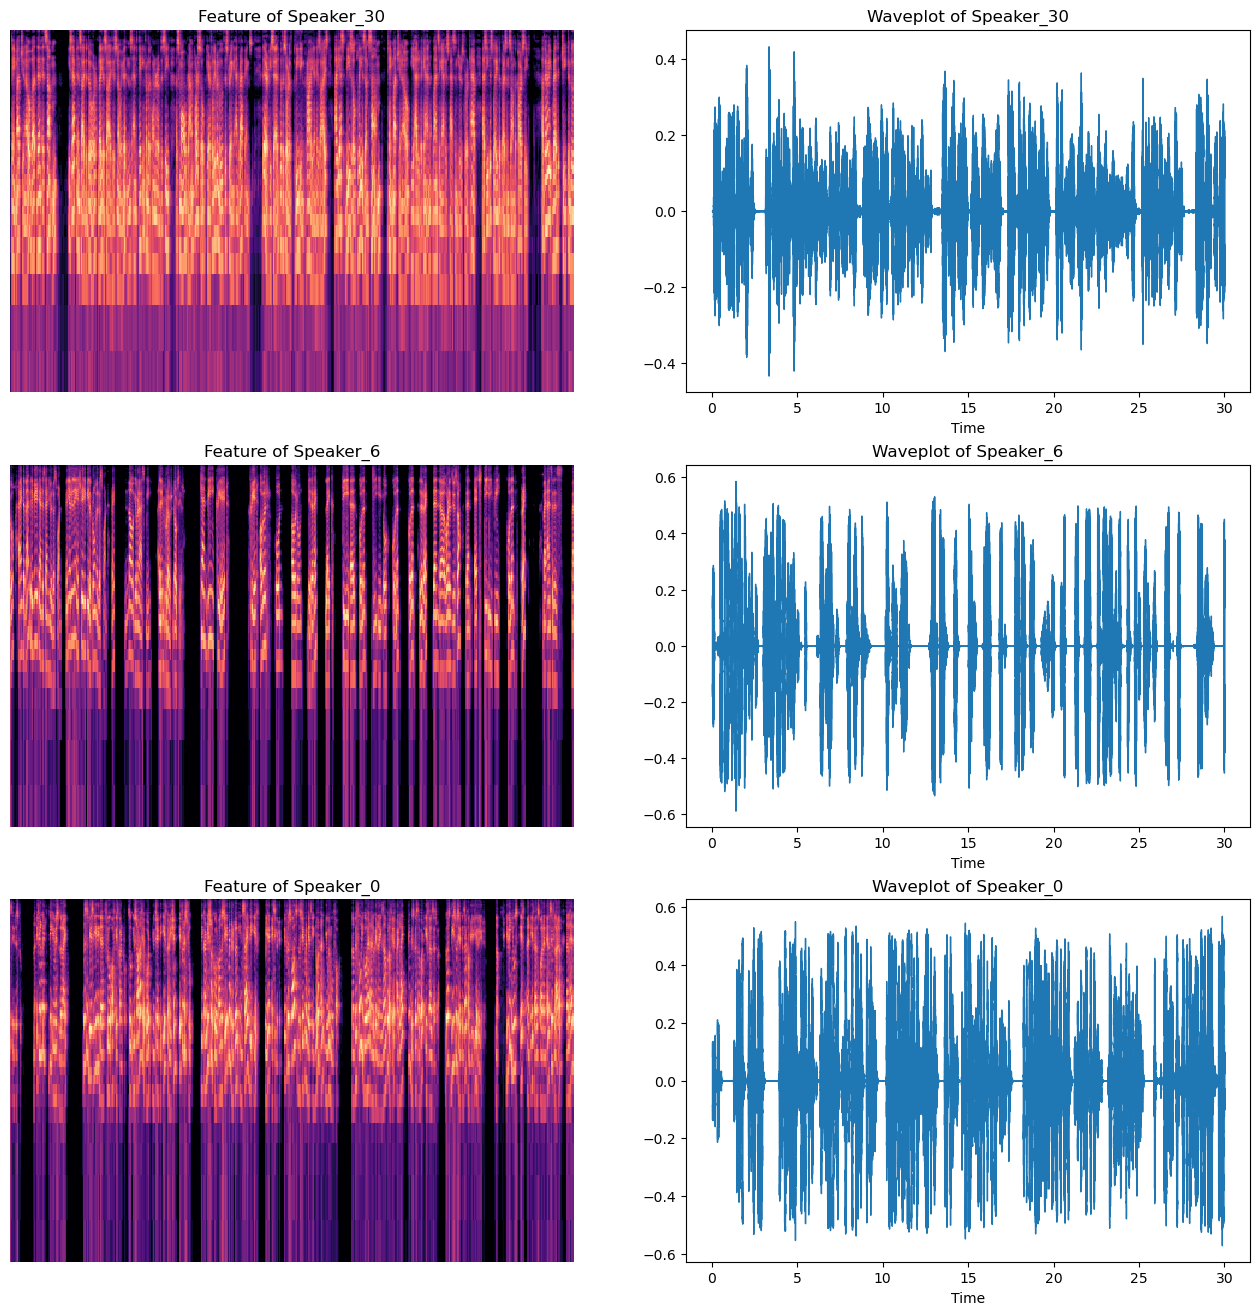

In [11]:
import random

print("[INFO] Plotting sample fragments of extracted features...")

plt.figure(figsize=(16, 16))

for i in range(3):
    n = random.randrange(len(features))
    plt.subplot(3, 2, 2*i + 1)
    librosa.display.specshow(features[n], sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Feature of Speaker_{labels[n]}')
    plt.axis("off")
    
    plt.subplot(3, 2, 2*i + 2)
    librosa.display.waveshow(truncated_file_data[n], sr=sr)
    plt.title(f'Waveplot of Speaker_{labels[n]}')


## Encode Labels

In [12]:
labels_onehot, class_onehot_mapping = onehot_encode(labels)

[INFO] Performing one-hot encoding on multiple nodes...
Mapping between column indices and original classes:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50}
Labels encoded using OneHotEncoder(), labels.shape: (2465, 50)


## Split train and test data

In [13]:
from sklearn.model_selection import train_test_split

# train:test 70:30
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.30, random_state=32)

# test:val 40:60
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.60, random_state=32)

# train: 70%, val: 18%, test: 12%


# Calculate the count of each class in the training set
train_class_counts = np.sum(y_train, axis=0)
train_class_dict = {f"Class {i}": count for i, count in enumerate(train_class_counts)}

# Calculate the count of each class in the validation set
val_class_counts = np.sum(y_val, axis=0)
val_class_dict = {f"Class {i}": count for i, count in enumerate(val_class_counts)}

# Calculate the count of each class in the test set
test_class_counts = np.sum(y_test, axis=0)
test_class_dict = {f"Class {i}": count for i, count in enumerate(test_class_counts)}

# Calculate the total number of samples in each set
total_train_samples = np.sum(train_class_counts)
total_val_samples = np.sum(val_class_counts)
total_test_samples = np.sum(test_class_counts)

# Print the class counts and percentages for each set aligned by class
max_len = max(len(key) for key in train_class_dict.keys())

print("Class".ljust(max_len + 5), "Train".ljust(15), "Validation".ljust(15), "Test".ljust(15))
print("-" * (max_len + 5 + 15 + 15 + 15))

for key in train_class_dict:
    percent_train = (train_class_dict[key] / total_train_samples) * 100
    percent_val = (val_class_dict[key] / total_val_samples) * 100
    percent_test = (test_class_dict[key] / total_test_samples) * 100

    print(key.ljust(max_len + 5),
          f"{train_class_dict[key]} ({percent_train:.2f}%)".ljust(15),
          f"{val_class_dict[key]} ({percent_val:.2f}%)".ljust(15),
          f"{test_class_dict[key]} ({percent_test:.2f}%)".ljust(15))

print(f'\nShape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Class         Train           Validation      Test           
----------------------------------------------------------
Class 0       71.0 (4.12%)    15.0 (3.38%)    7.0 (2.36%)    
Class 1       74.0 (4.29%)    28.0 (6.31%)    15.0 (5.07%)   
Class 2       78.0 (4.52%)    25.0 (5.63%)    16.0 (5.41%)   
Class 3       56.0 (3.25%)    16.0 (3.60%)    12.0 (4.05%)   
Class 4       62.0 (3.59%)    16.0 (3.60%)    11.0 (3.72%)   
Class 5       47.0 (2.72%)    15.0 (3.38%)    9.0 (3.04%)    
Class 6       48.0 (2.78%)    13.0 (2.93%)    14.0 (4.73%)   
Class 7       43.0 (2.49%)    16.0 (3.60%)    2.0 (0.68%)    
Class 8       72.0 (4.17%)    15.0 (3.38%)    11.0 (3.72%)   
Class 9       40.0 (2.32%)    10.0 (2.25%)    14.0 (4.73%)   
Class 10      36.0 (2.09%)    10.0 (2.25%)    7.0 (2.36%)    
Class 11      42.0 (2.43%)    15.0 (3.38%)    7.0 (2.36%)    
Class 12      28.0 (1.62%)    2.0 (0.45%)     3.0 (1.01%)    
Class 13      23.0 (1.33%)    8.0 (1.80%)     5.0 (1.69%)    
Class 14   

## Build a CNN model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

feature_width, feature_height = X_train.shape[1:3]

classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(feature_width, feature_height, 1), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(4, 4), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.
     
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(4, 4), padding='same', activation='relu'),
    Dropout(0.25),
     
    Flatten(),
    
    # # Use ReLU to avoid vanishing gradients problem
    Dense(1024, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25), #using a drop outs to avoid stepping to local minimums and labeling all samples to one class

    Dense(classes, activation='softmax'), # Categorical Classification: using softmax - multiple output nodes
])

# Tldr; I’ve seen a good rule-of-thumb is about 14-18x times the model size for memory limits, so for a 10GB card, training your model would max out memory at roughly 540M parameters.
model.summary()

2023-11-27 01:19:10.959265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 01:19:10.959521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 01:19:10.960777: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 01:19:11.050393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 01:19:13.024771: W tensorflow/compiler/

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 469, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 118, 64)       36928     
                                                                 
 dropout (Dropout)           (None, 32, 118, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 118, 128)      73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 30, 128)        147584    
                                                                 
 dropout_1 (Dropout)         (None, 8, 30, 128)        0         
                                                                 
 flatten (Flatten)           (None, 30720)             0

ead NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 01:19:15.415244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7393 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:05:00.0, compute capability: 8.6


In [15]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.001)
# crossentropy - Probabilistic losses
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#checkpoint = ModelCheckpoint('best_model_256.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# 1. *batch size* - defines the number of samples that will be propagated through the network. default 32
# one epoch = one forward pass and one backward pass of all the training examples batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
epochs=30

H = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val)) 

Epoch 1/30


2023-11-27 01:19:19.477223: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 414220800 exceeds 10% of free system memory.
2023-11-27 01:19:19.649067: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 414220800 exceeds 10% of free system memory.
2023-11-27 01:19:20.329466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-27 01:19:21.394190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-27 01:19:21.566743: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-27 01:19:22.103086: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-27 01:19:22.519729: I tensorflow/compiler/xla/

54/54 [==============================] - 8s 53ms/step - loss: 4.3074 - accuracy: 0.0319 - val_loss: 3.8563 - val_accuracy: 0.0383
Epoch 2/30
54/54 [==============================] - 2s 30ms/step - loss: 3.8788 - accuracy: 0.0446 - val_loss: 3.8348 - val_accuracy: 0.0563
Epoch 3/30
54/54 [==============================] - 2s 30ms/step - loss: 3.8625 - accuracy: 0.0481 - val_loss: 3.7230 - val_accuracy: 0.0563
Epoch 4/30
54/54 [==============================] - 2s 30ms/step - loss: 3.6354 - accuracy: 0.0504 - val_loss: 3.2919 - val_accuracy: 0.1351
Epoch 5/30
54/54 [==============================] - 2s 30ms/step - loss: 3.1349 - accuracy: 0.1217 - val_loss: 2.4306 - val_accuracy: 0.2635
Epoch 6/30
54/54 [==============================] - 2s 30ms/step - loss: 2.6443 - accuracy: 0.2046 - val_loss: 2.0101 - val_accuracy: 0.3018
Epoch 7/30
54/54 [==============================] - 2s 30ms/step - loss: 2.1268 - accuracy: 0.3322 - val_loss: 1.5110 - val_accuracy: 0.4775
Epoch 8/30
54/54 [======

10/10 [==============================] - 0s 36ms/step
Predicted | Actual |  Confidence   |
   2      |   2    |    99.99   %  |  ✔ 
   42     |   42   |    99.65   %  |  ✔ 
   29     |   29   |    100.00  %  |  ✔ 
   1      |   1    |    100.00  %  |  ✔ 
   40     |   40   |    76.58   %  |  ✔ 
   5      |   4    |    63.71   %  |  ✘ 
   8      |   8    |    99.91   %  |  ✔ 
   48     |   48   |    100.00  %  |  ✔ 
   33     |   33   |    100.00  %  |  ✔ 
   0      |   0    |    99.65   %  |  ✔ 
   32     |   38   |    98.33   %  |  ✘ 
   21     |   21   |    100.00  %  |  ✔ 
   24     |   24   |    100.00  %  |  ✔ 
   40     |   40   |    98.95   %  |  ✔ 
   29     |   29   |    99.86   %  |  ✔ 
   9      |   9    |    100.00  %  |  ✔ 
   12     |   12   |    99.42   %  |  ✔ 
   21     |   21   |    100.00  %  |  ✔ 
   48     |   48   |    100.00  %  |  ✔ 
   8      |   8    |    87.99   %  |  ✔ 
   48     |   48   |    100.00  %  |  ✔ 
   9      |   9    |    100.00  %  |  ✔ 
   26  

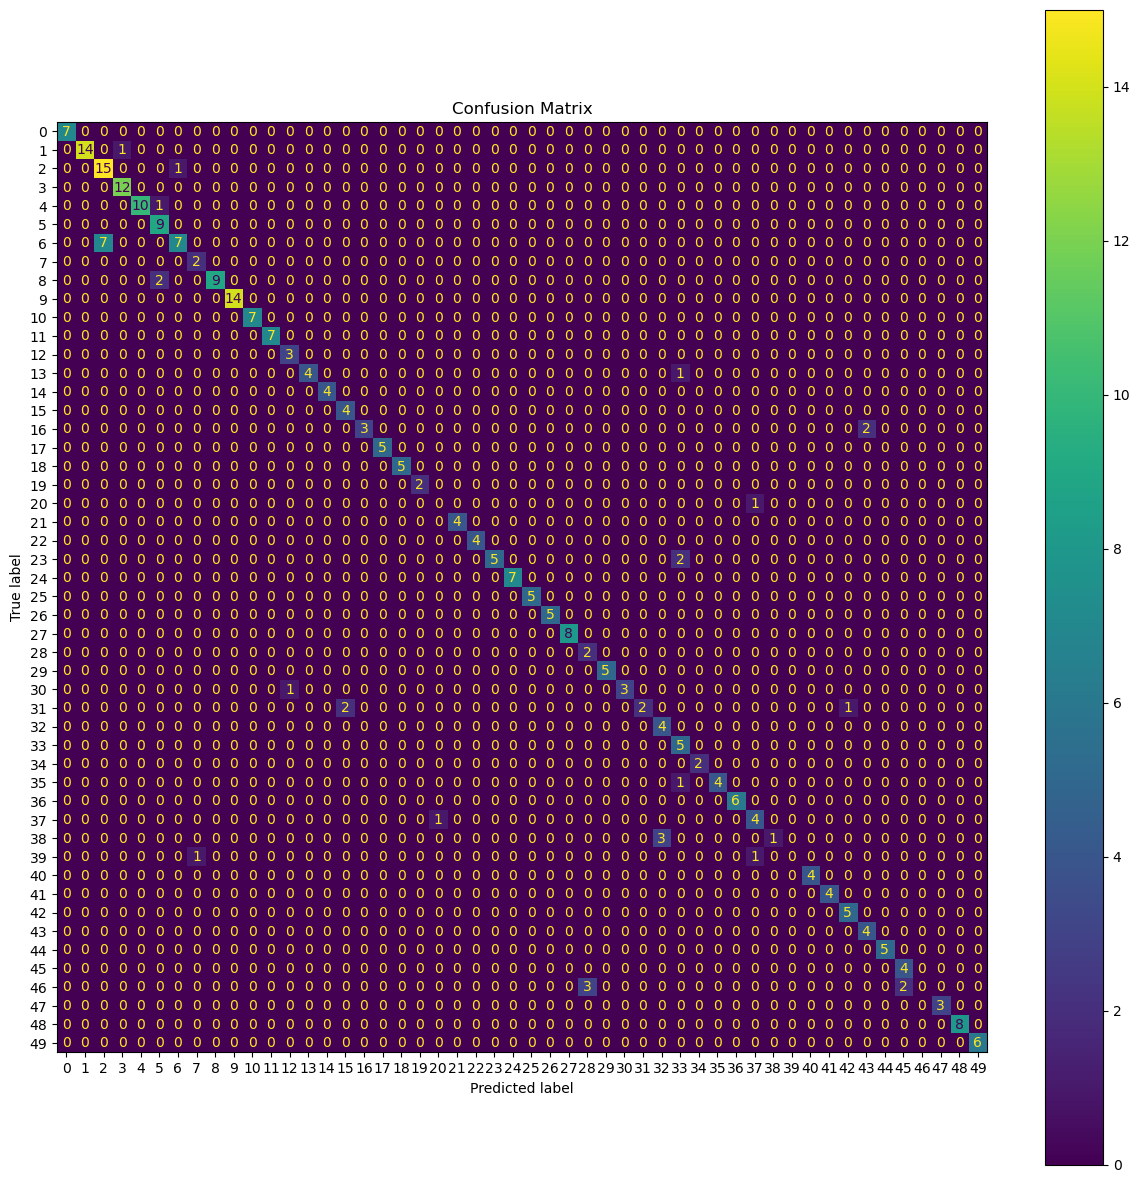

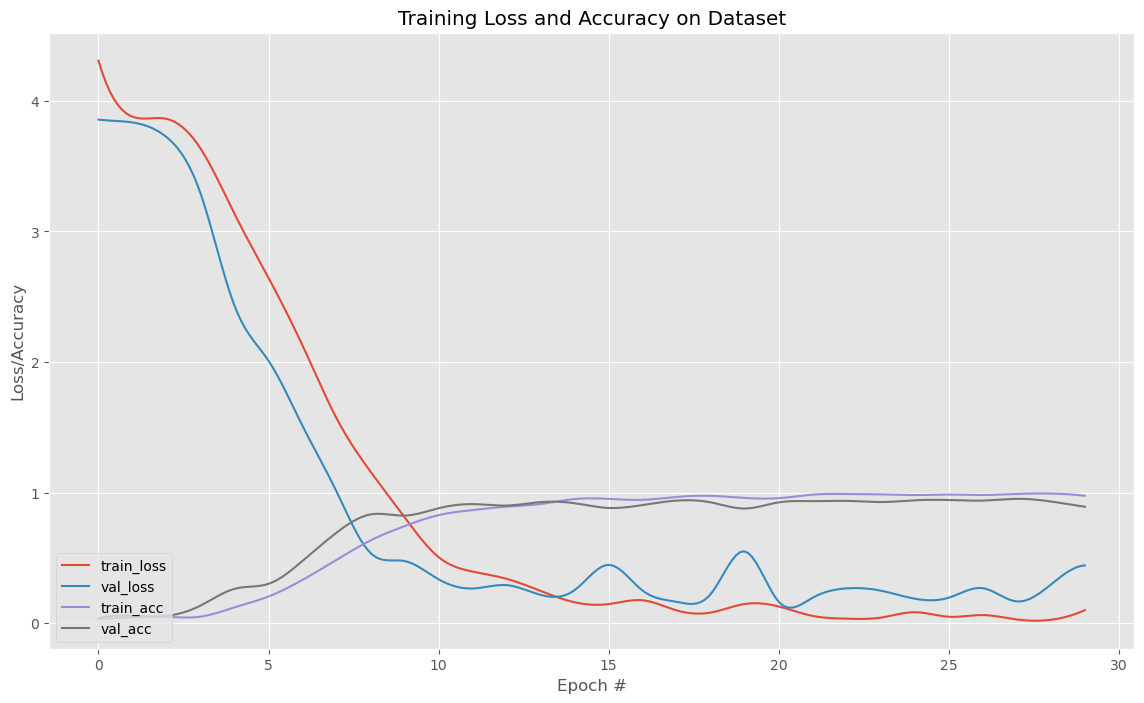

In [16]:
y_pred = model.predict(X_test)

y_pred_confidence = np.max(y_pred, axis=1)


y_pred = np.argmax(y_pred, axis=1) # softmax predictions need to be rounded 
y_pred = np.array(y_pred.tolist()) 

if y_pred.shape != y_test.shape:
    y_test = np.argmax(y_test, axis=1) 
    y_test = np.array(y_test.tolist()) 


print('Predicted | Actual |  Confidence   |')
for i in range(0, len(y_pred)):
    correct = '✔' if y_pred[i] == y_test[i] else '✘'
    print(f'{y_pred[i]:^8}  |  {y_test[i]:^4}  |  {y_pred_confidence[i]*100:^10.2f}%  |  {correct:^2}')
        
    
evaluate_model(H, y_pred, y_test, epochs)